# Memory task using BPTT

In [1]:
from functools import partial
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
from jax.scipy.special import logsumexp
from jax.lax import scan
import matplotlib.pyplot as plt
import numpy as np
import sys

from disp import set_plot, colors

D = jnp.array(1)

DT = jnp.array(.001)
TAU = jnp.array(.01)
B = jnp.eye(D)
C = jnp.eye(D)

N = jnp.array(2000)  #000)
G = jnp.array(100)

key = random.key(0)
J_PSI = G*random.normal(key, (N, 1))

# rand sgm kernel
def psi(x):
    return (jnp.tanh(J_PSI@x)+1)/2*(jnp.sqrt(2/N))

U = jnp.zeros(D)
X_0S = jnp.array([[1.], [-1.]])
TARGS = jnp.array([1., -1.])

T_MAXS = [.03, 1]

NEPOCH = 500
W_0 = jnp.zeros((N, D))

print('JAX', jax.__version__, jax.devices())

JAX 0.4.30 [CpuDevice(id=0)]


In [2]:
def f(x_, u_, W):
    x_ = x_ + (DT/TAU)*(-x_ + C@W.T@psi(x_) + B@u_)
    return x_, x_

def make_u(t_max, key_=1):
    t_max = jnp.array(t_max)
    t = jnp.arange(0, t_max, DT)
    
    key = random.key(key_)
    u = jnp.array(0.0)*random.normal(key, (len(t), 1))/jnp.sqrt(DT)
    
    return u, t

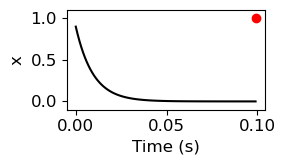

In [3]:
# test forward pass
u, t = make_u(t_max=.1)
x = scan(partial(f, W=W_0), X_0S[0], u)[1]

fig, ax = plt.subplots(1, 1, figsize=(3, 1.75), tight_layout=True)
ax.plot(t, x, c='k')
ax.scatter(t[-1], TARGS[0], c='r')
set_plot(ax, y_lim=(-.1, 1.1), x_label='Time (s)', y_label='x')

In [4]:
ALPHAS = .1*jnp.ones(NEPOCH)

losses_all = []

for t_max in T_MAXS:
    
    sys.stdout.write(f't_max={t_max}')
    u, t = make_u(t_max=t_max)
    
    def loss_fn(W):
        x_test_0 = scan(partial(f, W=W), X_0S[0], u)[1]
        loss_0 = jnp.abs(x_test_0[-1, 0]-TARGS[0])**2
        
        x_test_1 = scan(partial(f, W=W), X_0S[1], u)[1]
        loss_1 = jnp.abs(x_test_1[-1, 0]-TARGS[1])**2
        return (loss_0 + loss_1)/2
    
    def grad_fn(W):
        return grad(loss_fn)(W)
    
    def train(W, alphas):
    
        Ws = []
        losses = []
        grads = []
    
        for cepoch, alpha in enumerate(alphas):
            if cepoch % 10 == 0:
                sys.stdout.write('.')
    
            loss = loss_fn(W)
            losses.append(loss)
    
            grad = grad_fn(W)
            grads.append(grad)
    
            W -= alpha*grad
            Ws.append(W)
    
        return Ws, losses, grads
        
    Ws, losses, grads = train(W_0, ALPHAS)
    losses_all.append(losses.copy())
    
    print('')

t_max=0.03..................................................
t_max=1..................................................


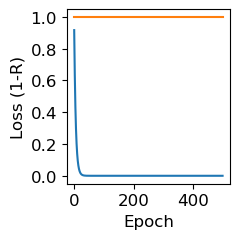

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), tight_layout=True)
for losses in losses_all:
    ax.plot(losses)
set_plot(ax, x_label='Epoch', y_label='Loss (1-R)')

fig.savefig('ms/5_hold_loss_bptt_jax.svg')

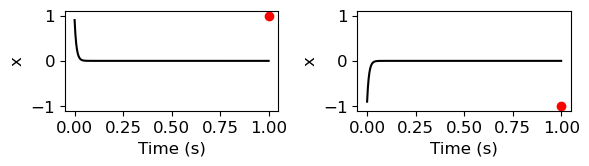

In [8]:
# test forward pass
u, t = make_u(t_max=t_max)

x_test_0 = scan(partial(f, W=Ws[-1]), X_0S[0], u)[1]
x_test_1 = scan(partial(f, W=Ws[-1]), X_0S[1], u)[1]

fig, axs = plt.subplots(1, 2, figsize=(6, 1.75), tight_layout=True)
axs[0].plot(t, x_test_0, c='k')
axs[0].scatter(t[-1], TARGS[0], c='r')
set_plot(axs[0], y_lim=(-1.1, 1.1), x_label='Time (s)', y_label='x')

axs[1].plot(t, x_test_1, c='k')
axs[1].scatter(t[-1], TARGS[1], c='r')
set_plot(axs[1], y_lim=(-1.1, 1.1), x_label='Time (s)', y_label='x')